# Feature Engineered Random Forest

## Extract Transform Load

In [92]:
confirmed_lc_path = "data/confirmed_lightcurves"
false_lc_path = "data/false_lightcurves"

In [93]:
import pandas as pd
import numpy as np
import os

In [94]:
def get_csv_data(file_path):
    df = pd.read_csv(file_path)
    df = df.iloc[:, :13]
    df = df.drop(["QUALITY", "ORBITID"], axis=1)
    df = df.rename(
          columns={
              "KSPSAP_FLUX": "DET_FLUX",
              "KSPSAP_FLUX_ERR": "DET_FLUX_ERR",
              "KSPSAP_FLUX_SML": "DET_FLUX_SML",
              "KSPSAP_FLUX_LAG": "DET_FLUX_LAG",
          }
      )
    df = df.dropna()
    df = df[~df.isin([np.inf]).any(axis=1)]
    return df



In [96]:
def engineer_features(df):

    df = remove_outliers(df, 'SAP_FLUX')
    df = remove_outliers(df, 'SAP_X')
    df = remove_outliers(df, 'SAP_Y')
    df = remove_outliers(df, 'SAP_BKG')
    df = remove_outliers(df, 'DET_FLUX_ERR')
    df = remove_outliers(df, 'SAP_BKG_ERR')

    features = {}

    features['mean_sap_flux'] = df['SAP_FLUX'].mean()
    features['median_sap_flux'] = df['SAP_FLUX'].median()

    features['std_sap_flux'] = df['SAP_FLUX'].std()
    features['var_sap_flux'] = df['SAP_FLUX'].var()
    features['range_sap_flux'] = df['SAP_FLUX'].max() - df['SAP_FLUX'].min()
    features['iqr_sap_flux'] = df['SAP_FLUX'].quantile(0.75) - df['SAP_FLUX'].quantile(0.25)

    features['skew_sap_flux'] = df['SAP_FLUX'].skew()
    features['kurt_sap_flux'] = df['SAP_FLUX'].kurt()

    features['10th_percentile_sap_flux'] = df['SAP_FLUX'].quantile(0.1)
    features['90th_percentile_sap_flux'] = df['SAP_FLUX'].quantile(0.9)

    features['mean_sap_x'] = df['SAP_X'].mean()
    features['std_sap_x'] = df['SAP_X'].std()
    features['mean_sap_y'] = df['SAP_Y'].mean()
    features['std_sap_y'] = df['SAP_Y'].std()

    features['mean_sap_bkg'] = df['SAP_BKG'].mean()
    features['std_sap_bkg'] = df['SAP_BKG'].std()

    features['mean_det_flux_err'] = df['DET_FLUX_ERR'].mean()
    features['std_det_flux_err'] = df['DET_FLUX_ERR'].std()
    features['mean_sap_bkg_err'] = df['SAP_BKG_ERR'].mean()
    features['std_sap_bkg_err'] = df['SAP_BKG_ERR'].std()

    return features

In [97]:
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

In [98]:
def process_lightcurves_and_save_features(lc_path, save_path):
    features = []
    for lc in os.listdir(lc_path):
        if lc.endswith(".csv"):
            df = get_csv_data(os.path.join(lc_path, lc))
            features.append(engineer_features(df))
    features_df = pd.DataFrame(features)
    features_df.to_csv(save_path, index=False)

In [99]:
confirmed_feature_path = "data/confirmed_feature_engineered.csv"
false_feature_path = "data/false_feature_engineered.csv" 
# check if files don't exist
if not os.path.exists(confirmed_feature_path):
    process_lightcurves_and_save_features(confirmed_lc_path, confirmed_feature_path)
if not os.path.exists(false_feature_path):
    process_lightcurves_and_save_features(false_lc_path, false_feature_path)

## Train the Model

In [100]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier

In [101]:
confirmed_df = pd.read_csv(confirmed_feature_path)
false_df = pd.read_csv(false_feature_path)

confirmed_df['label'] = 1
false_df['label'] = 0

In [102]:
features_df = pd.concat([confirmed_df, false_df])
features_df.dropna(inplace=True)


In [103]:
X = features_df.drop('label', axis=1)
y = features_df['label']

In [104]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [105]:
feature_engineered_rf = RandomForestClassifier(n_estimators=100, random_state=42)

In [106]:
feature_engineered_rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [107]:
y_pred = feature_engineered_rf.predict(X_test)

In [108]:
def evaluate_model(y_test, y_pred):
    print('Accuracy:', accuracy_score(y_test, y_pred))
    print('Precision:', precision_score(y_test, y_pred))
    print('Recall:', recall_score(y_test, y_pred))
    print('F1 Score:', f1_score(y_test, y_pred))
    cv_scores = cross_val_score(feature_engineered_rf, X, y, cv=5, scoring='f1')
    print(f"Cross-Validation F1 Score: {np.mean(cv_scores)}")
    print(f"Mean Cross-Validation F1 Score: {np.mean(cv_scores)}")


In [109]:
estimator_range = list(range(10,310,20))
accuracy_list = []
precision_list = []
recall_list = []
f1_list = []

In [110]:
for n_estimators in estimator_range:
    rf = RandomForestClassifier(n_estimators=n_estimators, random_state=42)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    accuracy_list.append(accuracy_score(y_test, y_pred))
    precision_list.append(precision_score(y_test, y_pred))
    recall_list.append(recall_score(y_test, y_pred))
    f1_list.append(f1_score(y_test, y_pred))
    

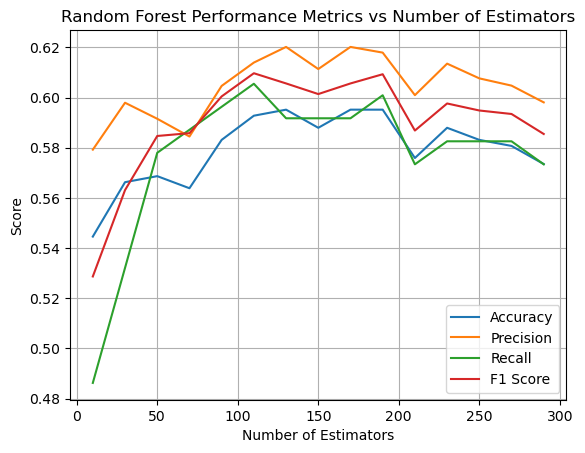

In [111]:
from matplotlib import pyplot as plt
plt.plot(estimator_range, accuracy_list, label='Accuracy')
plt.plot(estimator_range, precision_list, label='Precision')
plt.plot(estimator_range, recall_list, label='Recall')
plt.plot(estimator_range, f1_list, label='F1 Score')
plt.xlabel('Number of Estimators')
plt.ylabel('Score')
plt.title('Random Forest Performance Metrics vs Number of Estimators')
plt.legend()
plt.grid(True)
plt.show()

In [112]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 150, 180, 200],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

rf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv = 3, n_jobs=-1, verbose=2, scoring='f1')

grid_search.fit(X_train, y_train)

print("Best Parameters: ", grid_search.best_params_)
best_grid = grid_search.best_estimator_
y_pred = best_grid.predict(X_test)

evaluate_model(y_test, y_pred)

Fitting 3 folds for each of 288 candidates, totalling 864 fits
Best Parameters:  {'bootstrap': True, 'max_depth': 20, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
Accuracy: 0.6024096385542169
Precision: 0.6267942583732058
Recall: 0.6009174311926605
F1 Score: 0.613583138173302
Cross-Validation F1 Score: 0.618647088858315
Mean Cross-Validation F1 Score: 0.618647088858315


## Testing with Model Stacking

In [113]:
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import Pipeline

In [114]:
selector = SelectFromModel(RandomForestClassifier(n_estimators=100, random_state=42))

pipeline = Pipeline([
    ('feature_selection', selector),
    ('classification', RandomForestClassifier(n_estimators=180, random_state=42))
])
pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)
evaluate_model(y_test, y_pred)

Accuracy: 0.6
Precision: 0.6226415094339622
Recall: 0.6055045871559633
F1 Score: 0.613953488372093
Cross-Validation F1 Score: 0.618647088858315
Mean Cross-Validation F1 Score: 0.618647088858315


## Save Model Using Joblib

In [115]:
import joblib
if not os.path.exists('models'):
    os.makedirs('models')

joblib.dump(best_grid, 'models/feature_engineered_rf_model.pkl')

['models/feature_engineered_rf_model.pkl']